In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

In [5]:
%matplotlib inline

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [6]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

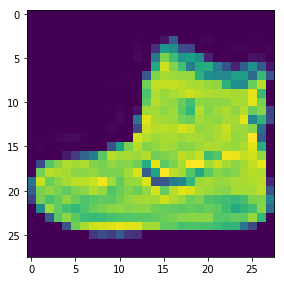

In [13]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
ax.imshow(X_train[0].reshape([28,28]))

### Задание:
Будем решать задачу классификации на 10 классов. Каждый класс соответствует одному из типов одежды. Исходная размерность признакового пространства: `784`, каждый пиксель является признаком. Будем снижать размерность признакового пространства с помощью метода главных компонент (`PCA`). Ваша задача оценить качество решенения задачи классификации по метрике `accuracy` в зависимости от числа главных компонент. Также оцените дисперсию функции качества в зависимости от числа главных компонент.

Нарисуйте график зависимости функции качества и ее дисперсии от числа главных компонент.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого числа главных компонент  стоит повторять многократно на различных случайных подвыборках.*

In [7]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [15]:
pca = PCA(n_components=3)
used_indices = np.random.choice(np.arange(X_train.shape[0]), 10000, replace=True)
X_train_lowdim = pca.fit_transform(X_train[used_indices].reshape([-1, 784]))
lr = LogisticRegression()
lr.fit(X_train_lowdim, y_train[used_indices])
accuracy_score(y_test, lr.predict(pca.transform(X_test.reshape([-1, 784]))))

0.58069999999999999

Используйте следующую сетку числа главных компонент: `[3, 5, 7, 12, 18, 25, 33, 40, 48, 55]`. Для ускорения сходимости можете семплировать подвыборки из `X_train`. 

In [8]:
from tqdm import tqdm
TRAIN_SIZE = 10000

In [24]:
num_components = [3, 5, 7, 12, 18, 25, 33, 40, 48, 55]

score_list = []
mean_score_list = []
var_score_list = []
num_iterations = 10
for num in tqdm(num_components):  
    for _ in range(num_iterations):
        pca = PCA(n_components=num)
        used_indices = np.random.choice(np.arange(X_train.shape[0]), TRAIN_SIZE, replace=False)
        X_train_lowdim = pca.fit_transform(X_train[used_indices])
        lr = LogisticRegression()
        lr.fit(X_train_lowdim, y_train[used_indices])
        score_list.append(accuracy_score(y_test, lr.predict(pca.transform(X_test))))
    mean_score_list.append(np.mean(score_list))
    var_score_list.append(np.var(score_list))
    score_list = []


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:30<00:00, 292.87s/it]


## График зависимости функции качества  от числа главных компонент.

In [24]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})

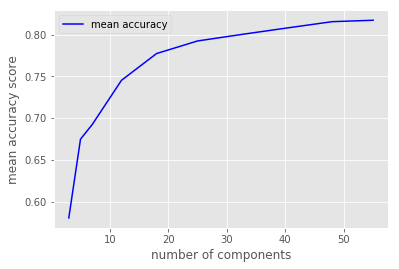

In [25]:
plt.plot(num_components, mean_score_list, 'b', label='mean accuracy')
plt.xlabel('number of components')
plt.ylabel('mean accuracy score')
plt.legend(loc='upper left')
plt.show()

## График зависимости оценки дисперсии функции качества от числа главных компонент.

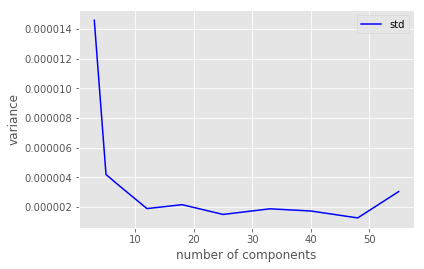

In [26]:
plt.plot(num_components, var_score_list, 'b', label='std')
plt.xlabel('number of components')
plt.ylabel('variance')
plt.legend(loc='upper right')
plt.show()

## Пробный анализ ошибки

Зависимость значения ошибки и его стандартного отклонения от объема выборки на обучении и контроле.

In [12]:
N_COMPONENTS = 50 # уменьшение размерности для быстрого подсчета

In [21]:
train_size = np.hstack([np.arange(50, 500, 50), np.arange(500, 2000, 100), np.arange(2000, 10000, 2000)])


score_list = []
mean_score_list = []
std_score_list = []
num_iterations = 5
for size in tqdm(train_size):
    for _ in range(num_iterations):
        pca = PCA(n_components=N_COMPONENTS)
        used_indices = np.random.choice(np.arange(X_train.shape[0]), size, replace=False)
        X_train_lowdim = pca.fit_transform(X_train[used_indices])
        lr = LogisticRegression()
        lr.fit(X_train_lowdim, y_train[used_indices])
        score_list.append(accuracy_score(y_test, lr.predict(pca.transform(X_test))))
    mean_score_list.append(np.mean(score_list))
    std_score_list.append(np.std(score_list))
    score_list = []


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [08:03<00:00, 71.11s/it]


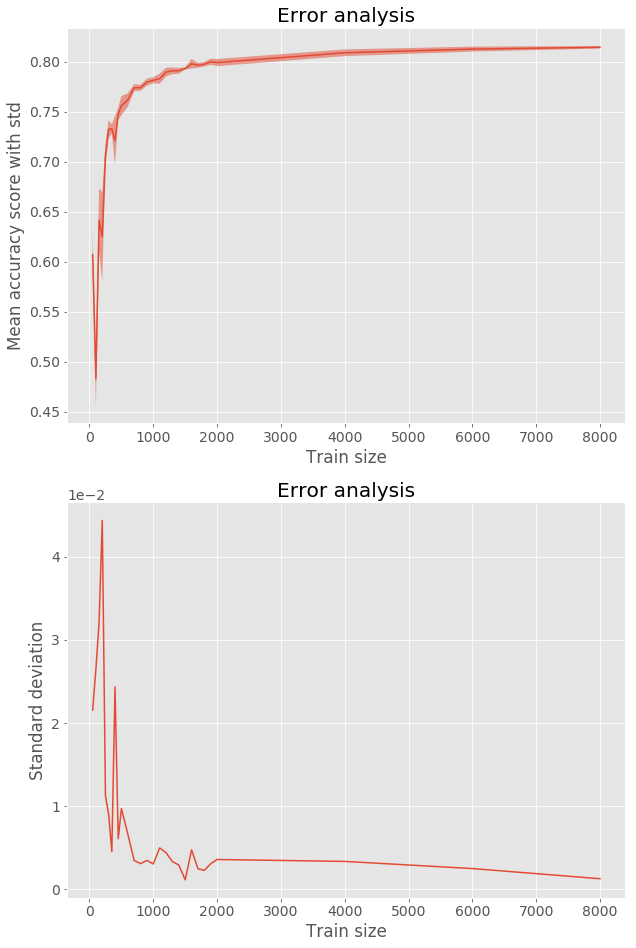

In [28]:
means = np.array(mean_score_list)
stds = np.array(std_score_list)

_, ax = plt.subplots(2, 1, figsize=(10, 16))
ax[0].plot(train_size, mean_score_list,  '-', ms=10)
ax[0].fill_between(train_size, means-stds, 
                         means+stds, alpha=0.5)
ax[0].set_title('Error analysis')
ax[0].set_xlabel('Train size')
ax[0].set_ylabel('Mean accuracy score with std')

ax[1].plot(train_size, stds, '-')
ax[1].set_title('Error analysis')
ax[1].set_xlabel('Train size')
ax[1].set_ylabel('Standard deviation')

plt.ticklabel_format(axis='y',style='sci',scilimits=(1,3))
plt.show()